In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

data/resized/000034.jpg


In [2]:
# %load_ext blackcellmagic
# todo custom loss to bump up brigtness
isDataset2 = False
continueTrain = True
dataDir = "data/stl10/" if isDataset2 else "data/resized/"
biggerNet = True
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform' ##
activation = 'relu'#LeakyReLU(alpha=0.3)
finalActivation = 'relu' # 'sigmoid'
normalize = finalActivation == 'sigmoid' # normalizing output hinders this training
colorspace = ['lab','rgb','hsv'][0]
rgb = colorspace == 'rgb'
lab = colorspace == 'lab'
trainSplitPercent = 0.8 # 0.8
valSplitPercent = 0.02 # 0.02


data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSize = int(len(data_IDs)*trainSplitPercent)

dataset size 202599


In [3]:
def showHsv(img):    
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif lab:
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
#     hue = K.square(huePred - hueTrue) 
    
    hue2 = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue2, saturation], axis=-1) # predictedHue was 0 when order is reversed

def saturationLoss(yTrue, yPred):
    multiplier = 1 / K.sqrt(K.abs( (yPred[...,0] - 128) * (yPred[...,1] - 128)) +0.1)
    a =  K.square(yTrue[...,0] - yPred[...,0]) 
    b =  K.square(yTrue[...,1] - yPred[...,1]) 
    return K.concatenate([a*multiplier, b*multiplier], axis=-1)
    
def mapOutOfGreen(m):
    '''maps green colors into others'''
    minGreen, maxGreen = 42, 63
    target = 160
    r = np.copy(m)
    r[(r >= minGreen) & (r<=maxGreen)] = (r[(r >= minGreen) & (r<=maxGreen)] - minGreen) +  target
    # smoother transition
    d = 7
    lower = minGreen - d
    sel = r[(r < minGreen) & (r>= lower)]
    r[(r < minGreen) & (r>= lower)] = (sel - lower) /d * (target - lower) + sel

    higher = maxGreen + d
    sel = r[(r > maxGreen) & (r<= higher)]
    r[(r > maxGreen) & (r<= higher)] = (sel - higher) /d * (target - higher) + sel
    return r

def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    if rgb:
        RGB, v = hs[0], v[0,...,0]
        print('rgb.shape',RGB.shape)
        img = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)
    else:
        hs, v = hs[0], v[0,...,0]
        #print('hs:',hs.shape)
        h, s = hs[...,0], hs[...,1]
        #h = mapOutOfGreen(h)
        #print('h',h.shape,'s',s.shape,'v',v.shape)
        #print(h.dtype, s.dtype, v.dtype)
        hsv = cv2.merge([v,h,s] if lab else [h,s,v] )
        img = cv2.cvtColor(hsv, cv2.COLOR_LAB2RGB if lab else cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
        
    f, axarr = plt.subplots(1,4 + 1*rgb, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    titles = ['blue', 'green', 'red','value'] if rgb else ['A','B','L'] if lab else ['hue', 'saturation', 'value']
    for i in range(3 if rgb else 2,-1,-1):
        if rgb:
            pic = RGB[:,:,i] if i < 3 else v
        elif lab:
            pic = hsv[:,:,-i-1]
        else:
            pic = hsv[:,:,i]
        axarr[1+i].title.set_text(titles[i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    inX, inY = loadImg(img )
    inX, inY = inX[None,...,None], inY[None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)
    if not rgb:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print(f'{"A" if lab else "hue"}:', predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
        print(f'{"B" if lab else "sat"}:', predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    else:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('red:',predY[...,2].min(), predY[...,2].max(), predY[...,2].mean() )
        print('green:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
        print('blue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    if normalize:
        # hue and sat [0,1] -> their range
        predY[...,0] *= 180
        predY[...,1] *= 255
    else:
        if not rgb:
            predY[...,0] = predY[...,0] % 181
        else:
            predY = np.minimum(predY, 255)
        predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    if not rgb:
        hue = predY[...,0]
        print(f'{"A" if lab else "hue"} uint8', hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        fname = f'data/stl10/unlabeled_image_png_{i}.png' if isDataset2 else f'data/resized/{i:06}.jpg'
        predictFromImage(fname, True) 

In [4]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB if lab else cv2.COLOR_BGR2HSV)
print(hsv.shape)
print('''LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.''')
h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 180).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv2 = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv2); showHsv(hsv)

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
(1008, 1600, 3)
LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.


In [5]:
def loadImg(path):
    '''
    returns X - value
            Y - (hue, saturation) or (blue, green, red) or (L, A, B)
    '''
    img_in = cv2.imread(path)
    if lab:
        LAB = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(LAB)
        return l, np.dstack((a,b))
        
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    if rgb:
        b,g,r = cv2.split(img_in)
        Y = np.dstack((b,g,r))
    else:
        Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# stl10 dataset from https://www.kaggle.com/jessicali9530/stl10
# 100,000 images of size 96x96

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
#         self.hsstd = np.sqrt(var[...,:2])
#         self.hsmean = mean[...,:2]
#         self.vstd = np.sqrt(var[...,2])
#         self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImg(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
        if normalize:
            Y[...,0] /= 180 # was [0] by mistake
            Y[...,1] /= 255
#             X /= 255
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [6]:
params = {'dim': (96, 96) if isDataset2 else (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 3 if rgb else 2,
          'shuffle': True}
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

# params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))

training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)

train len 162079
val len 4051
(32, 128, 128, 2)


In [7]:
def createModel(input_shape, bigger, mul, initializer, activation, finalActivation):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = activation, padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge7)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(3 if rgb else 2, 1, activation = finalActivation, padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
model.summary()
print(model.output_shape)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
____________________________

In [8]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
if continueTrain:
    countEpochs = 1
    model.load_weights('data/lab_big_train_set.h5')
else:
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=1,
                        use_multiprocessing=False,
                        workers=0,
                        callbacks=[tensorboard])
    countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.
# predictions(trainSize, 10)

unet_bigger_mul2_he_normal08-06-2019-16-04-24


In [14]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
model.save_weights('lab_fully_trained.h5')
# model.load_weights('data/stl.h5')

Epoch 3/3
5064/5064 [==============================] - 1372s 271ms/step - loss: 116.3109 - mean_absolute_error: 7.2277 - mean_squared_error: 116.3109 - val_loss: 115.6865 - val_mean_absolute_error: 7.1782 - val_mean_squared_error: 115.6865
predy 122.861664 149.45215 135.21585 (1, 128, 128, 2)
A: 123.67046 149.45215 133.63686
B: 122.861664 149.3795 136.79483
predy uint8 122 149 134.71063232421875
A uint8 123 149 133.1331787109375


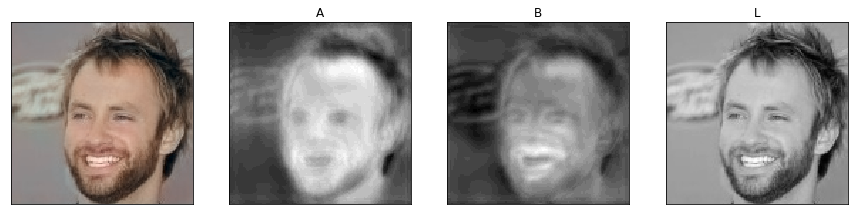

In [12]:
for i in range(1,2):
    #start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
    predictions(trainSize+i, 1)

countEpochs 3
predy 122.93982 150.82202 133.51866 (1, 128, 128, 2)
A: 123.38863 150.82202 131.89577
B: 122.93982 150.39752 135.14157
predy uint8 122 150 133.0177001953125
A uint8 123 150 131.38995361328125


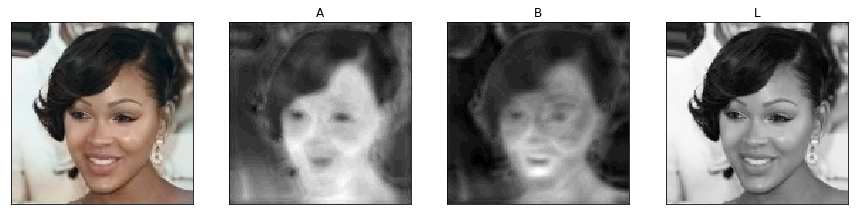

predy 121.5498 149.99797 133.79665 (1, 128, 128, 2)
A: 123.7422 149.03253 133.79305
B: 121.5498 149.99797 133.80026
predy uint8 121 149 133.30453491210938
A uint8 123 149 133.30987548828125


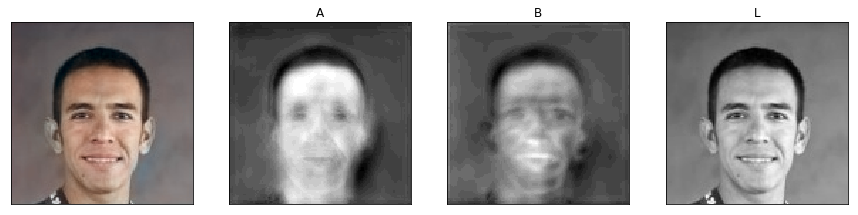

predy 120.55911 151.26955 133.53139 (1, 128, 128, 2)
A: 122.18244 148.57582 132.06657
B: 120.55911 151.26955 134.99622
predy uint8 120 151 133.0316162109375
A uint8 122 148 131.5640869140625


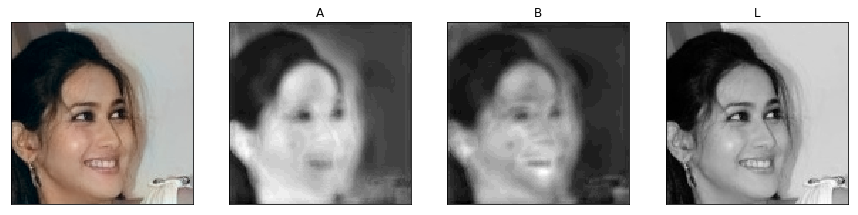

predy 118.03835 148.54692 133.17987 (1, 128, 128, 2)
A: 118.03835 148.54692 131.07887
B: 123.09239 148.15076 135.28087
predy uint8 118 148 132.68255615234375
A uint8 118 148 130.58135986328125


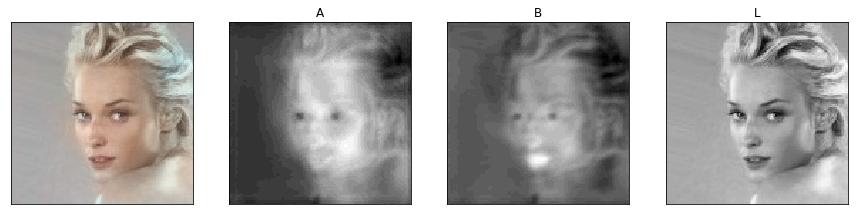

predy 121.16483 148.8392 134.14767 (1, 128, 128, 2)
A: 123.20384 148.8392 132.78539
B: 121.16483 148.27928 135.50995
predy uint8 121 148 133.65594482421875
A uint8 123 148 132.29412841796875


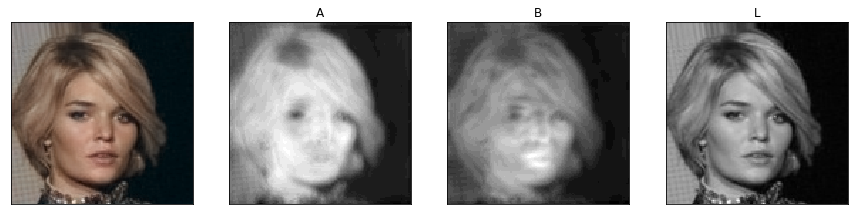

predy 123.52068 150.93942 133.58197 (1, 128, 128, 2)
A: 124.055855 150.93942 132.21896
B: 123.52068 150.79874 134.94495
predy uint8 123 150 133.08563232421875
A uint8 124 150 131.7205810546875


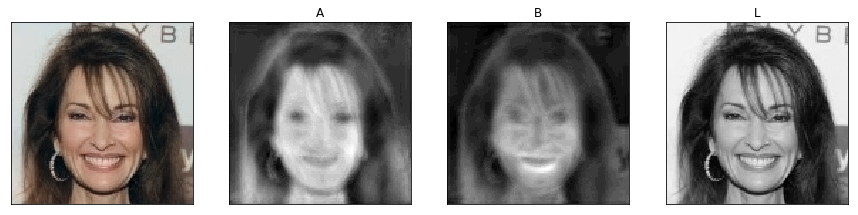

predy 121.58819 148.1376 133.22386 (1, 128, 128, 2)
A: 121.58819 148.10103 132.78986
B: 124.12077 148.1376 133.65784
predy uint8 121 148 132.72561645507812
A uint8 121 148 132.29168701171875


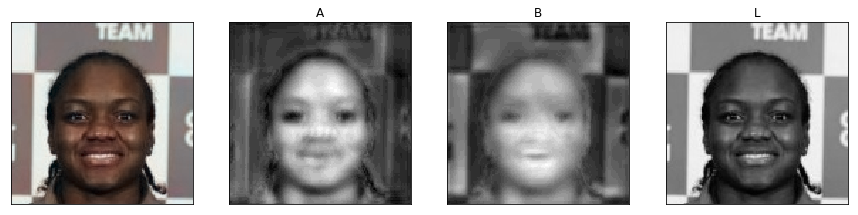

predy 121.9267 149.73253 135.15659 (1, 128, 128, 2)
A: 121.9267 148.7349 132.8611
B: 122.41526 149.73253 137.4521
predy uint8 121 149 134.65872192382812
A uint8 121 148 132.3671875


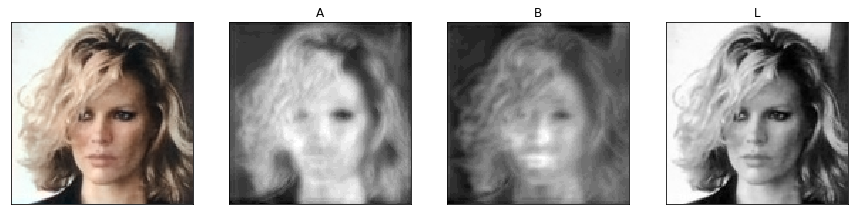

predy 119.327034 148.61284 130.09154 (1, 128, 128, 2)
A: 119.59099 145.3536 129.60957
B: 119.327034 148.61284 130.57349
predy uint8 119 148 129.58966064453125
A uint8 119 145 129.11114501953125


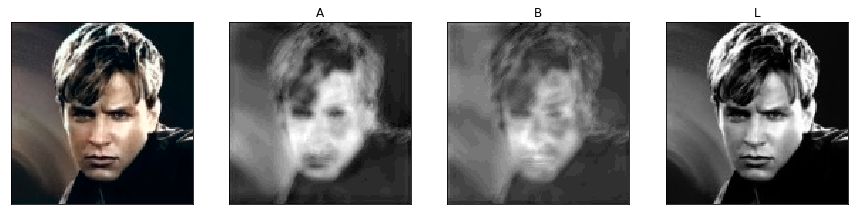

predy 120.94442 149.73561 133.34286 (1, 128, 128, 2)
A: 124.1543 149.49043 132.41324
B: 120.94442 149.73561 134.27248
predy uint8 120 149 132.84286499023438
A uint8 124 149 131.91412353515625


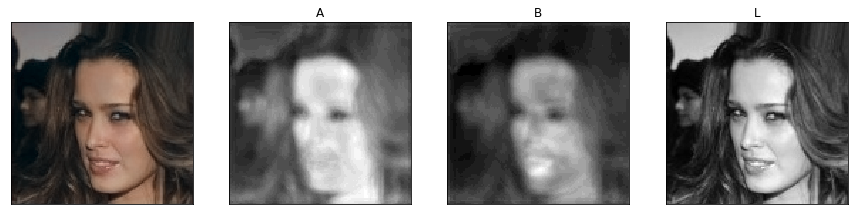

predy 122.62223 149.57088 133.69363 (1, 128, 128, 2)
A: 122.62223 147.16718 131.79565
B: 123.89189 149.57088 135.5916
predy uint8 122 149 133.19290161132812
A uint8 122 147 131.2916259765625


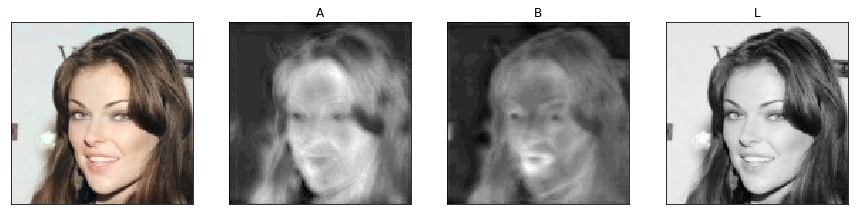

predy 121.73768 153.90938 132.9457 (1, 128, 128, 2)
A: 122.96026 153.90938 132.19783
B: 121.73768 148.83264 133.69359
predy uint8 121 153 132.44528198242188
A uint8 122 153 131.69573974609375


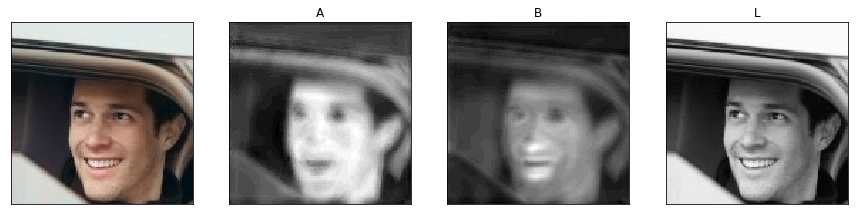

predy 123.49616 150.05917 133.61165 (1, 128, 128, 2)
A: 124.35104 146.33382 133.55588
B: 123.49616 150.05917 133.66743
predy uint8 123 150 133.10992431640625
A uint8 124 146 133.05560302734375


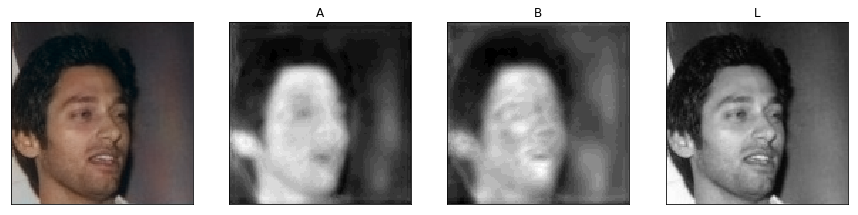

predy 121.665245 149.2175 134.11588 (1, 128, 128, 2)
A: 123.316284 143.23965 132.63712
B: 121.665245 149.2175 135.59464
predy uint8 121 149 133.61221313476562
A uint8 123 143 132.13934326171875


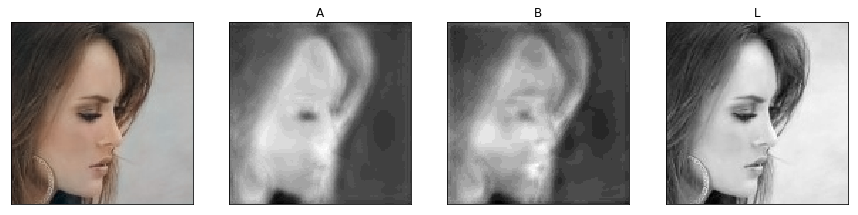

predy 120.784386 149.52367 135.17001 (1, 128, 128, 2)
A: 120.784386 149.52367 132.2684
B: 123.36162 148.20425 138.07161
predy uint8 120 149 134.67062377929688
A uint8 120 149 131.76910400390625


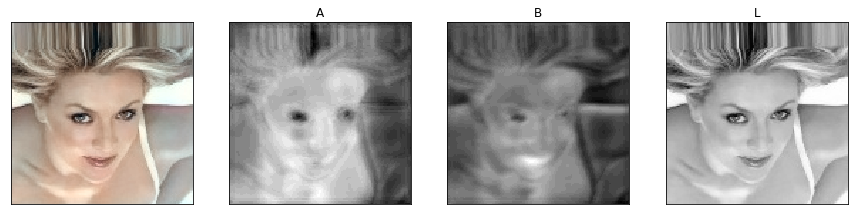

predy 121.86413 150.85359 133.7956 (1, 128, 128, 2)
A: 123.3655 148.24191 132.22108
B: 121.86413 150.85359 135.37013
predy uint8 121 150 133.29141235351562
A uint8 123 148 131.7117919921875


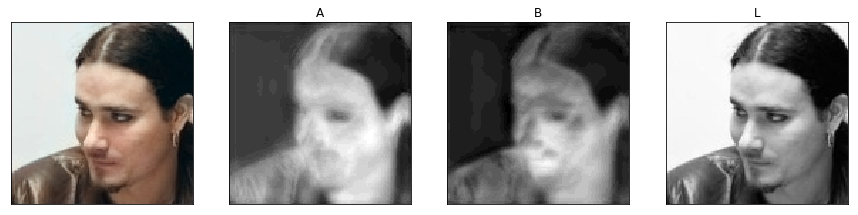

predy 120.46164 151.71024 130.15594 (1, 128, 128, 2)
A: 122.247116 151.71024 129.31465
B: 120.46164 149.38637 130.99725
predy uint8 120 151 129.65335083007812
A uint8 122 151 128.8177490234375


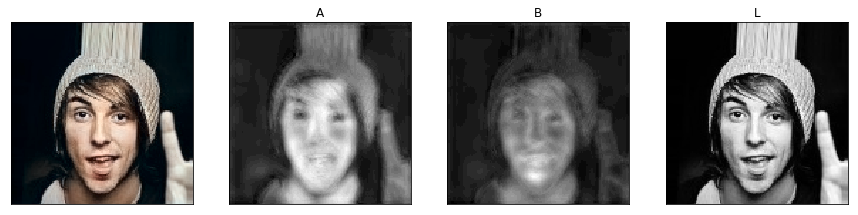

predy 120.97328 155.48465 132.27429 (1, 128, 128, 2)
A: 121.25817 155.48465 130.68015
B: 120.97328 151.90883 133.86841
predy uint8 120 155 131.77374267578125
A uint8 121 155 130.1798095703125


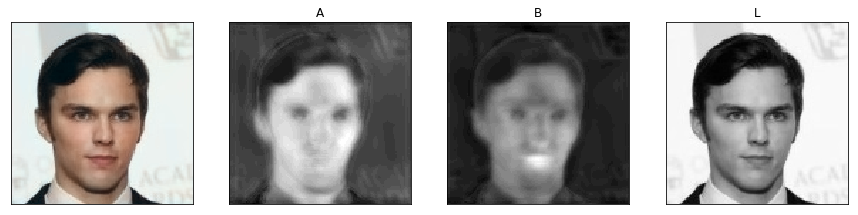

predy 121.26806 149.19177 137.2305 (1, 128, 128, 2)
A: 123.16961 149.19177 135.00848
B: 121.26806 148.6169 139.45248
predy uint8 121 149 136.73159790039062
A uint8 123 149 134.51226806640625


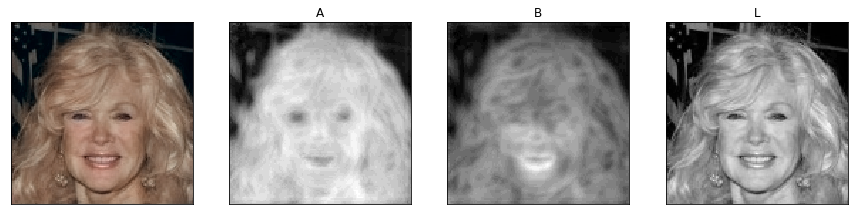

predy 120.25552 150.47021 132.02605 (1, 128, 128, 2)
A: 122.13813 150.47021 130.82864
B: 120.25552 149.63687 133.22345
predy uint8 120 150 131.52304077148438
A uint8 122 150 130.31695556640625


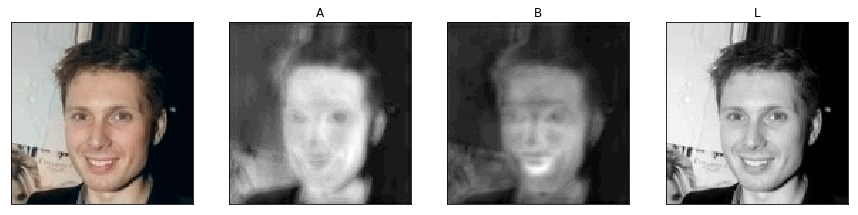

predy 120.60714 148.07222 133.51077 (1, 128, 128, 2)
A: 122.52955 145.70985 132.20233
B: 120.60714 148.07222 134.8192
predy uint8 120 148 133.0120849609375
A uint8 122 145 131.70623779296875


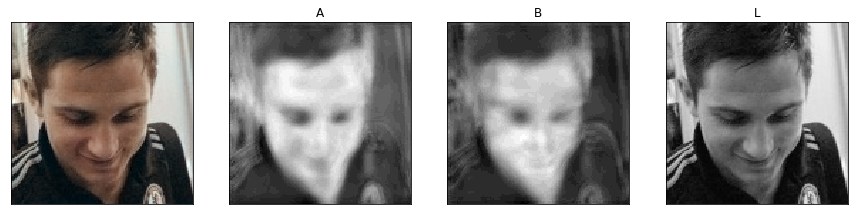

predy 121.102455 148.72604 133.65485 (1, 128, 128, 2)
A: 121.102455 148.63107 132.21815
B: 121.189705 148.72604 135.09155
predy uint8 121 148 133.15438842773438
A uint8 121 148 131.7174072265625


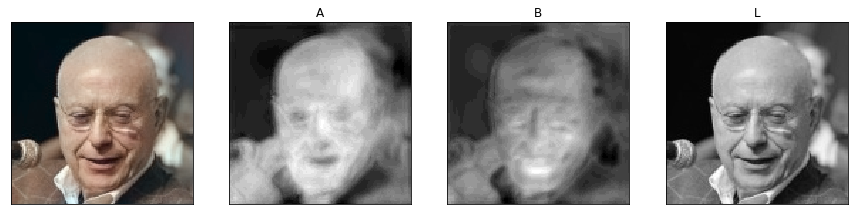

predy 121.452965 151.90225 137.10307 (1, 128, 128, 2)
A: 123.05123 151.90225 135.26276
B: 121.452965 150.38322 138.94339
predy uint8 121 151 136.6031494140625
A uint8 123 151 134.7626953125


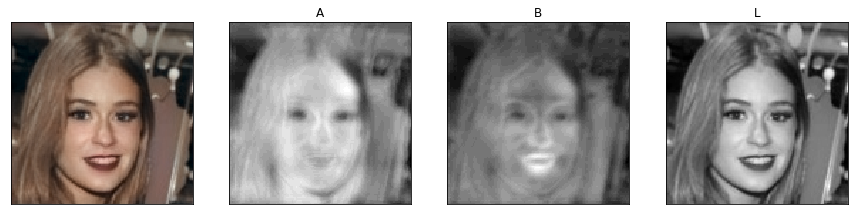

predy 117.8209 151.76173 131.94495 (1, 128, 128, 2)
A: 120.24587 151.76173 131.25783
B: 117.8209 150.67908 132.63205
predy uint8 117 151 131.44607543945312
A uint8 120 151 130.75396728515625


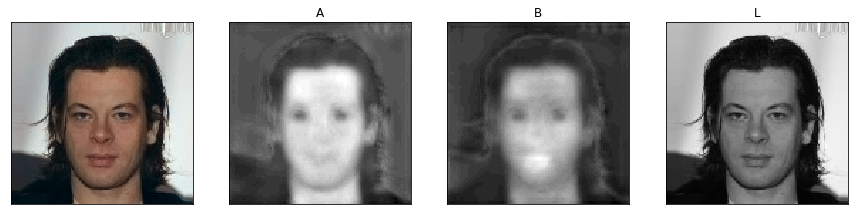

predy 118.867226 152.50359 132.31427 (1, 128, 128, 2)
A: 121.81045 146.39192 131.09354
B: 118.867226 152.50359 133.535
predy uint8 118 152 131.8148193359375
A uint8 121 146 130.5958251953125


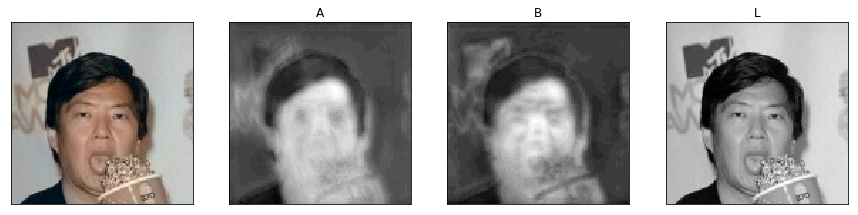

predy 121.28818 150.89204 131.33997 (1, 128, 128, 2)
A: 123.33912 149.31612 130.67444
B: 121.28818 150.89204 132.00548
predy uint8 121 150 130.841796875
A uint8 123 149 130.17633056640625


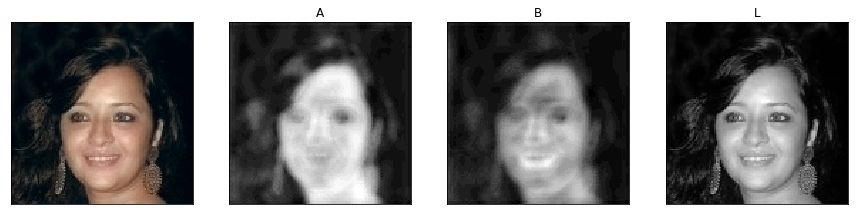

predy 122.48817 151.03383 133.12164 (1, 128, 128, 2)
A: 123.37662 148.83023 132.36172
B: 122.48817 151.03383 133.88153
predy uint8 122 151 132.62106323242188
A uint8 123 148 131.86114501953125


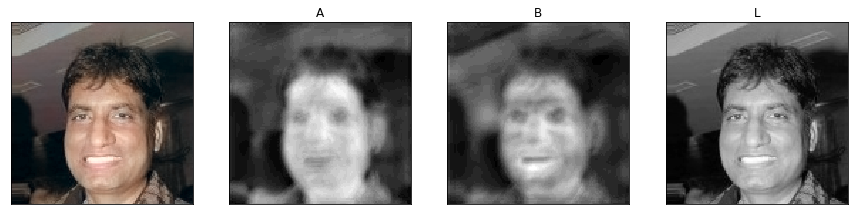

predy 118.87138 149.51245 132.37938 (1, 128, 128, 2)
A: 120.74537 147.43674 130.38968
B: 118.87138 149.51245 134.36908
predy uint8 118 149 131.88967895507812
A uint8 120 147 129.90008544921875


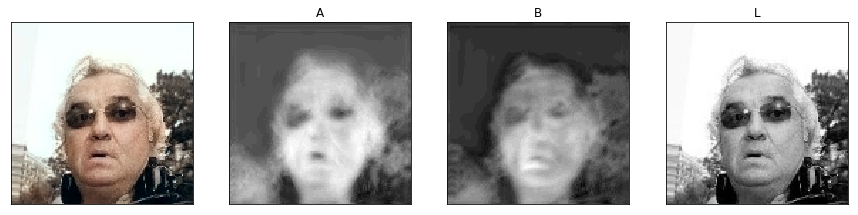

predy 124.47268 148.29231 135.30045 (1, 128, 128, 2)
A: 124.47268 146.64032 133.38776
B: 124.48405 148.29231 137.21313
predy uint8 124 148 134.79876708984375
A uint8 124 146 132.8857421875


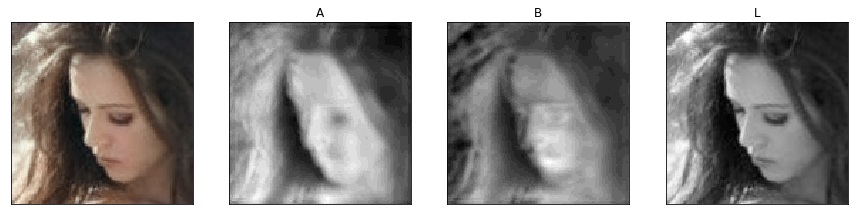

predy 120.2199 150.05249 132.54002 (1, 128, 128, 2)
A: 122.4743 145.4674 131.43817
B: 120.2199 150.05249 133.64188
predy uint8 120 150 132.03610229492188
A uint8 122 145 130.93780517578125


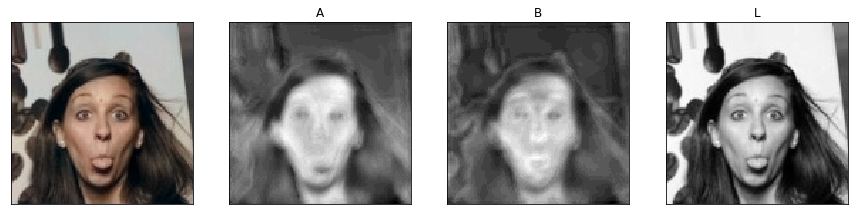

predy 121.74312 149.46123 136.38 (1, 128, 128, 2)
A: 123.24615 147.67264 133.87845
B: 121.74312 149.46123 138.88159
predy uint8 121 149 135.87686157226562
A uint8 123 147 133.3740234375


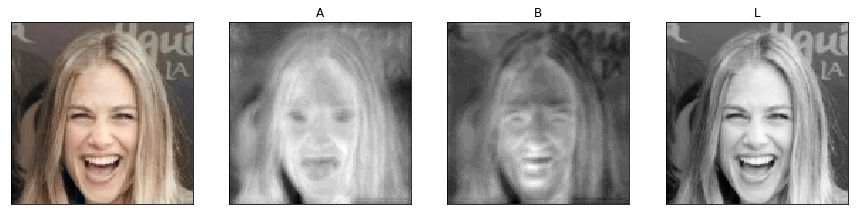

predy 121.44623 152.94798 134.66104 (1, 128, 128, 2)
A: 121.44623 152.94798 131.51843
B: 123.865616 149.97733 137.80363
predy uint8 121 152 134.1600341796875
A uint8 121 152 131.0146484375


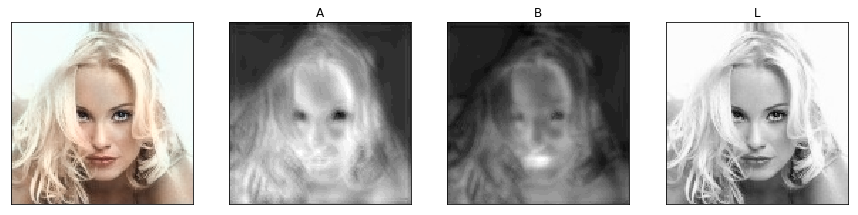

predy 120.49456 150.40524 129.43411 (1, 128, 128, 2)
A: 122.30399 149.83052 129.21292
B: 120.49456 150.40524 129.6553
predy uint8 120 150 128.92398071289062
A uint8 122 149 128.69970703125


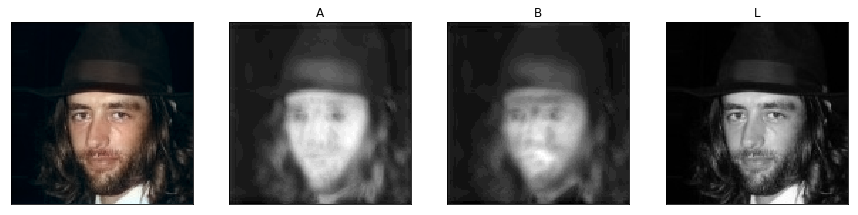

predy 121.12285 150.93713 133.19344 (1, 128, 128, 2)
A: 122.76557 146.66772 132.21991
B: 121.12285 150.93713 134.16696
predy uint8 121 150 132.69134521484375
A uint8 122 146 131.71209716796875


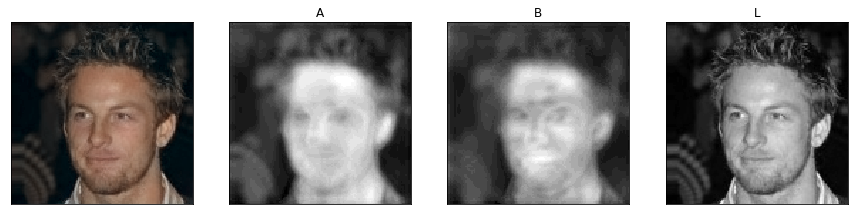

predy 121.15075 155.69125 132.43262 (1, 128, 128, 2)
A: 123.11775 155.69125 131.84879
B: 121.15075 150.43826 133.01643
predy uint8 121 155 131.9307861328125
A uint8 123 155 131.3463134765625


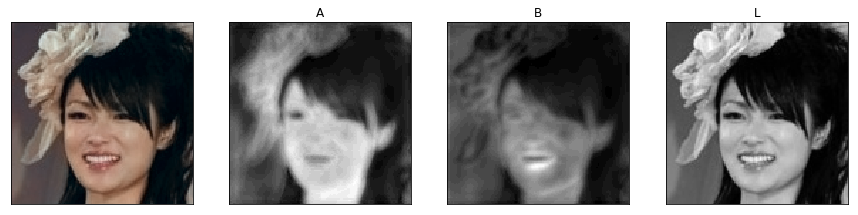

predy 121.019646 150.49745 135.70578 (1, 128, 128, 2)
A: 123.13938 149.94965 133.45126
B: 121.019646 150.49745 137.9603
predy uint8 121 150 135.20779418945312
A uint8 123 149 132.956298828125


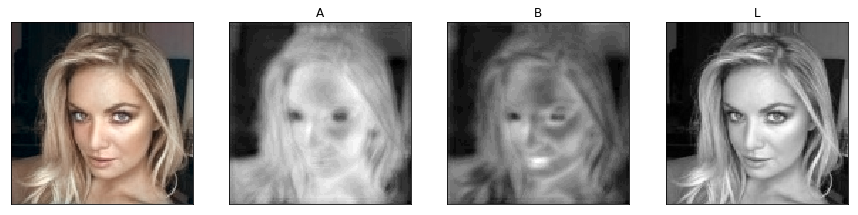

predy 120.50501 150.33148 132.12808 (1, 128, 128, 2)
A: 123.40288 146.94225 131.80386
B: 120.50501 150.33148 132.4523
predy uint8 120 150 131.629150390625
A uint8 123 146 131.302490234375


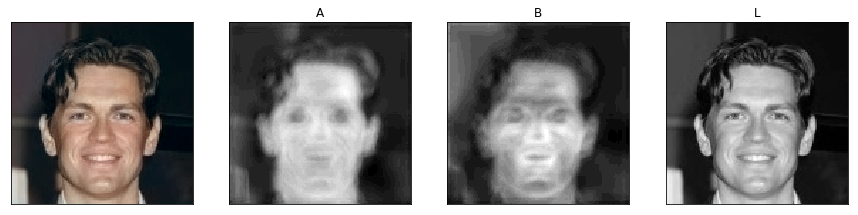

predy 124.99489 155.76503 136.85089 (1, 128, 128, 2)
A: 124.99489 155.76503 134.78333
B: 126.64726 149.23705 138.91846
predy uint8 124 155 136.3514404296875
A uint8 124 155 134.28253173828125


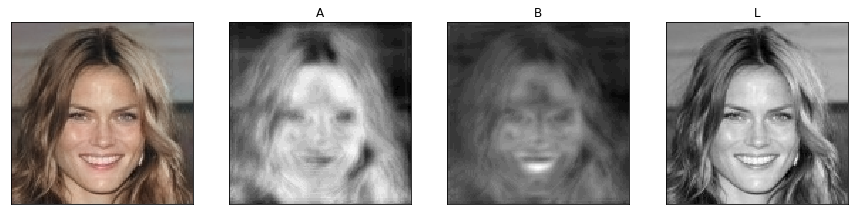

predy 121.08282 149.32637 132.94086 (1, 128, 128, 2)
A: 122.93962 149.32637 132.20375
B: 121.08282 148.12035 133.67798
predy uint8 121 149 132.4432373046875
A uint8 122 149 131.70648193359375


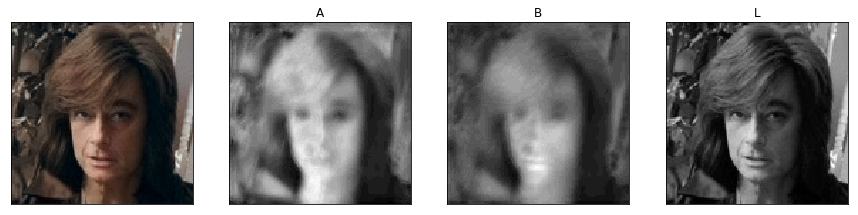

predy 120.24049 149.71579 132.33029 (1, 128, 128, 2)
A: 122.277626 147.84676 131.46683
B: 120.24049 149.71579 133.19373
predy uint8 120 149 131.83316040039062
A uint8 122 147 130.97186279296875


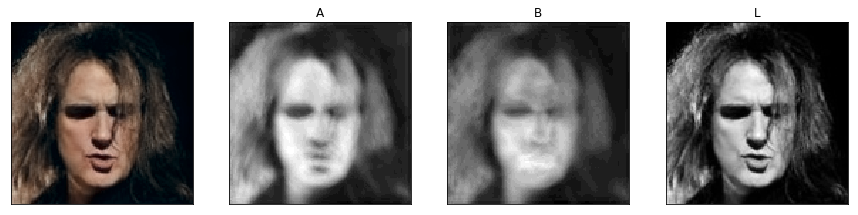

In [13]:
print('countEpochs',countEpochs)
predictions(trainSize+40, 40)


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    var, mean = getImagesVarAndMean([dataDir + idx for idx in train_IDs], params['dim'] + (3,))
    y = np.dstack([mean[...,0].astype('uint8'), mean[...,1].astype('uint8'), x.astype('uint8')])

    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['A','B','L'][i-1])
        plt.imshow(mean[...,i-1])
    plt.show()
    print("Input value with mean A and mean B:")
    showHsv(y)
nonMlBaseline()

In [ ]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

In [ ]:
model.save(f'data/{NAME}.h5')

In [ ]:
# print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
# batch=55
# print('testing channel ranges:')
# print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
# print(training_generator[batch][1].shape)
# h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
# s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
# v = training_generator[batch][0][0,...].astype('uint8')
# y = np.dstack([h , s, v ] )
# showHsv(y )
# print(h.min(), h.max())
# plt.imshow(h)

# show filters

# x1w = model.get_weights()[0][:,:,0,:]
# for i in range(1,26):
#   plt.subplot(5,5,i)
#   plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
# plt.show()

In [ ]:
def demo(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (128,128))
    cv2.imwrite("./tmp.jpg", img)
    predictFromImage("./tmp.jpg", True)
    try:
        os.remove("./tmp.jpg")
    except OSError:
        pass

In [ ]:
testSplit = int(trainSize + valSize)
test_IDs = data_IDs[testSplit:]
print('test len', len(val_IDs))
test_generator = DataGenerator(test_IDs, **params)
test_eval = model.evaluate_generator(test_generator)

In [ ]:
_ = [print (f'{x[0]}: {x[1]}') for x in zip(model.metrics_names, test_eval)]